# Comparing observed and modeled Atlantic Multidecadal Variability 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xeofs as xe
import intake
import pycwt as wavelet
import scipy.signal as signal

In [2]:
def global_average(data):
    weights = np.cos(np.deg2rad(data.lat))
    data_weighted = data.weighted(weights)
    return data_weighted.mean(dim=['lat', 'lon'], skipna=True)

In [3]:
def eof_analysis(da, nmodes, dim='time'):
    model = xe.models.EOF(n_modes=nmodes, standardize=True, use_coslat=True)
    model.fit(da, dim=dim)
    eofs = model.components()
    pcs = model.scores()
    expvar = model.explained_variance_ratio()

    return xr.merge([eofs, pcs, expvar])

## Data access

### Observational data (ERSSTv5)

In [4]:
data_url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ersst = xr.open_dataset(data_url).sst
ersst

<xarray.DataArray 'sst' (time: 2047, lat: 89, lon: 180)> Size: 131MB
[32792940 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2024-07-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

### Model data (CMIP6)

In [5]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [6]:
model_name = 'GFDL-CM4'
cat = col.search(source_id=model_name, experiment_id=['historical'], member_id='r1i1p1f1', table_id='Omon', variable_id='tos', grid_label='gr')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Omon,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701


In [7]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})
list(dset_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gr']

In [8]:
ds = dset_dict['CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gr']

## Prepare data

ERSSTv5 starts at 1854, while the CMIP6 historical runs end at 2014, so we will subset both datasets to that range:

In [9]:
model_sst = ds.tos.sel(time=slice('1854', '2014')).squeeze().drop_vars(['member_id', 'dcpp_init_year'])
obs_sst = ersst.sel(time=slice('1854', '2014'))

In [10]:
model_sst.time.size, obs_sst.time.size

(1932, 1932)

Deseasonalize and detrend data:

In [11]:
model_sst_clim = model_sst.groupby('time.month')
model_ssta = model_sst_clim - model_sst_clim.mean(dim='time')
model_ssta_dt = (model_ssta - global_average(model_ssta)).squeeze()

obs_sst_clim = obs_sst.groupby('time.month')
obs_ssta = obs_sst_clim - obs_sst_clim.mean(dim='time')
obs_ssta_dt = (obs_ssta - global_average(obs_ssta)).squeeze()

Select North Atlantic region:

In [12]:
def na(da):
    return da.where((da.lat > 0) & (da.lat < 80) & (da.lon > 290) & (da.lon < 360), drop=True)

na_model_ssta_dt = na(model_ssta_dt)
na_obs_ssta_dt = na(obs_ssta_dt)

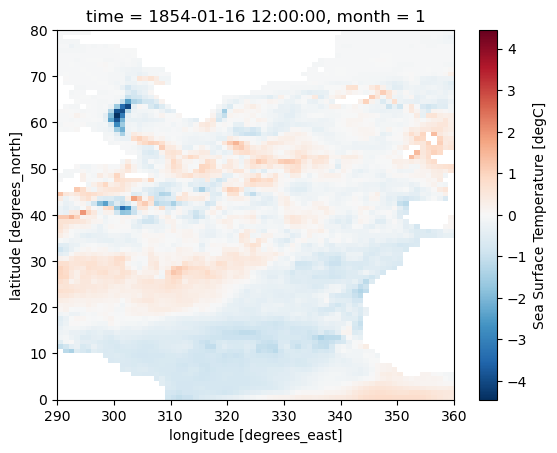

/home/jovyan/ohw24_proj_north_atlantic_variability_us/.pixi/envs/default/lib/python3.11/site-packages/dask/array/numpy_compat.py:60: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [13]:
na_model_ssta_dt.isel(time=0).plot()

## Analysis of variability

### AMV index

Atlantic Multidecadal Variability is [usually defined as the average SST anomaly over the Atlantic basin 0-80N](https://climatedataguide.ucar.edu/climate-data/atlantic-multi-decadal-oscillation-amo). 

In [14]:
model_amv = global_average(na_model_ssta_dt)
model_amv_annual = model_amv.groupby('time.year').mean()
model_amv_std = np.std(model_amv.data)
model_amv_norm = model_amv/model_amv_std

obs_amv = global_average(na_obs_ssta_dt)
obs_amv_annual = obs_amv.groupby('time.year').mean()
obs_amv_std = np.std(obs_amv.data)
obs_amv_norm = obs_amv/obs_amv_std

Text(0, 0.5, 'K')

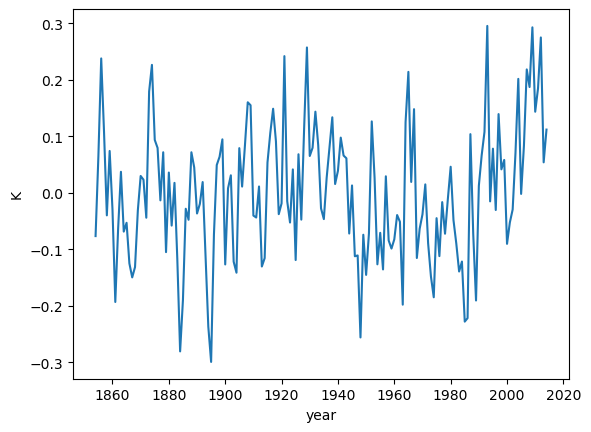

In [15]:
model_amv_annual.plot()
plt.ylabel('K')

### EOFs
We can also try running an EOF analysis on the NA region, which we can compare to the AMV index.

In [16]:
%%time
na_obs_eofa = eof_analysis(na_obs_ssta_dt.groupby('time.year').mean(), 4, dim='year')
na_model_eofa = eof_analysis(na_model_ssta_dt.groupby('time.year').mean(), 4, dim='year')

/home/jovyan/ohw24_proj_north_atlantic_variability_us/.pixi/envs/default/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CPU times: user 2min 19s, sys: 17.2 s, total: 2min 36s
Wall time: 2min 9s


In [17]:
obs_eof1 = na_obs_eofa.components.sel(mode=1)
model_eof1 = na_model_eofa.components.sel(mode=1)

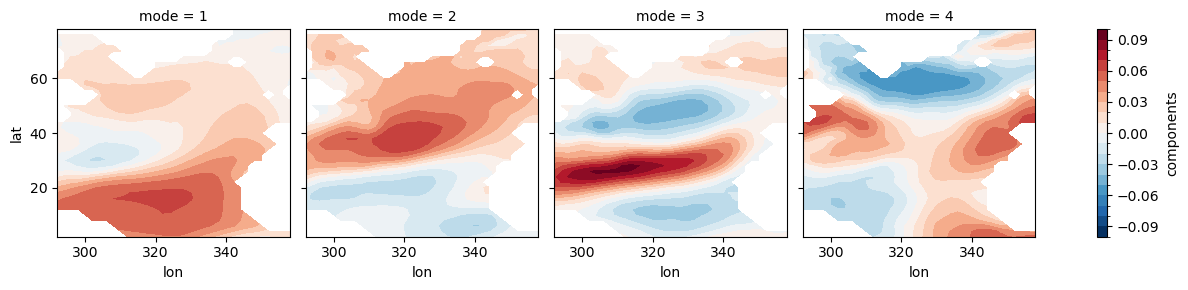

In [18]:
na_obs_eofa.components.plot.contourf(col='mode', levels=20)

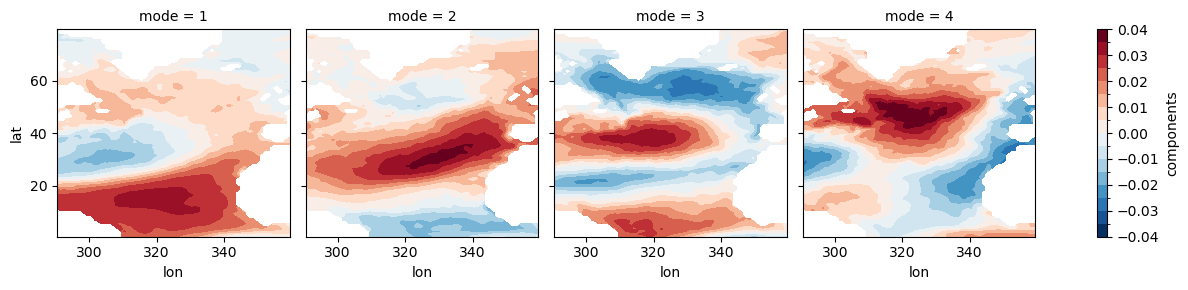

In [19]:
na_model_eofa.components.plot.contourf(col='mode', levels=20)

Since the EOF analysis does not capture the basin-wide SST variation characteristic of AMV, we will just compute and compare the spectra of the usual AMV index.

### Spectral analysis

In [41]:
mod_f, mod_P = signal.periodogram(model_amv_norm)
obs_f, obs_P = signal.periodogram(obs_amv_norm)

/tmp/ipykernel_772/1080917630.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(2*np.pi/mod_f/12, mod_P, label=model_name)
/tmp/ipykernel_772/1080917630.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(2*np.pi/obs_f/12, obs_P, label='ERSSTv5')


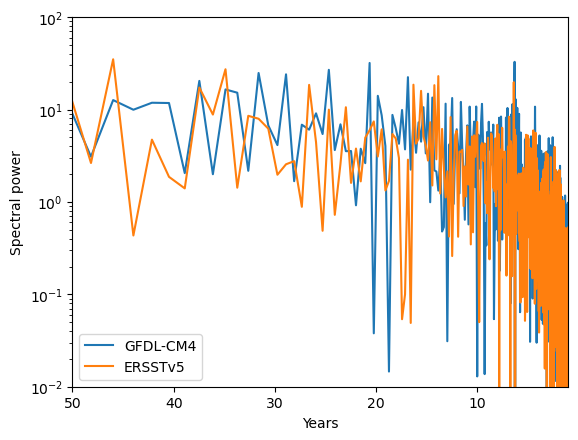

In [51]:
plt.plot(2*np.pi/mod_f/12, mod_P, label=model_name)
plt.plot(2*np.pi/obs_f/12, obs_P, label='ERSSTv5')
plt.xlabel('Years')
plt.ylabel('Spectral power')
plt.yscale('log')
plt.xlim(1, 50)
plt.gca().invert_xaxis()
plt.ylim(1e-2, 1e2)
plt.legend()